# CNN-Based Rotation Correction - Advanced Machine Learning Project

### Matteo Breganni 869549

# Imports

In [1]:
from google.colab import drive
import zipfile
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math

import random as random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
cv2.setRNGSeed(0)
rng = np.random.default_rng(0)

# Dataset creation and split

The dataset is split between train, val and test sets and each image is divided into one or more squares to augment the number of images in each set, avoiding warping them later (which can destroy some of the spatial information and make predictions harder) when they will have to be reshaped to be taken as the input of the CNN.

In [2]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/drive')
shutil.copy('/content/drive/My Drive/landscape.zip', 'landscape.zip')
zipf = zipfile.ZipFile('landscape.zip')
zipf.extractall()
zipf.close()

os.remove('landscape.zip') # Delete the copied zip file

Mounted at /content/drive


In [3]:
#shutil.rmtree("dataset")

The images in the extracted folder are split between train, val and test sets with a 60-20-20 split and moved in their respective folders.

In [4]:
extracted_folder = "landscape"
dataset_folder = "dataset"
train_folder = os.path.join(dataset_folder, "train")
val_folder = os.path.join(dataset_folder, "val")
test_folder = os.path.join(dataset_folder, "test")

if(not os.path.exists(dataset_folder)):
    os.makedirs(dataset_folder)
    os.makedirs(train_folder)
    os.makedirs(val_folder)
    os.makedirs(test_folder)

    # Get all image files in the extracted_folder
    all_images = sorted([f for f in os.listdir(extracted_folder) if os.path.isfile(os.path.join(extracted_folder, f))])
    all_images = rng.permutation(all_images)

    # Calculate split sizes for 60-20-20
    total_images = len(all_images)
    train_count = int(total_images * 0.6)
    val_count = int(total_images * 0.2)

    # Split and move images
    train_images = all_images[:train_count]
    val_images = all_images[train_count:train_count + val_count]
    test_images = all_images[train_count + val_count:]
    for img in train_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(train_folder, img))
    for img in val_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(val_folder, img))
    for img in test_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(test_folder, img))

    # Check if extracted_folder is empty
    if not os.listdir(extracted_folder):
        os.rmdir(extracted_folder)  # Remove the empty folder
    else:
        print(f"Error: The folder '{extracted_folder}' is not empty. Remaining files: {os.listdir(extracted_folder)}")

print(f"Split completed: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")

Split completed: 42 train, 14 val, 14 test images.


In [5]:
def split_images_into_squares(folder_path):
    """
    Splits each image in the given folder into square images of size smaller_axis x smaller_axis.
    The resulting images are saved in the same folder and the original image is deleted after splitting.
    """
    # Get a sorted list of filenames in the folder
    filenames = sorted(os.listdir(folder_path))

    for filename in filenames:
        file_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(file_path) as img:
            width, height = img.size
            #print("img size:", img.size)
            smaller_axis = min(width, height)

            # Calculates the amount of images per axis
            tot_images_x = math.ceil(width / smaller_axis)
            tot_images_y = math.ceil(height / smaller_axis)
            #print("tot_images_x:", tot_images_x)
            #print("tot_images_y:", tot_images_y)

            # Calculate the amount of sliding per axis
            slide_w = slide_h = 0  # Default to 0 if no sliding is needed
            if tot_images_x > 1:
                slide_w = (width - smaller_axis) / (tot_images_x - 1)
            if tot_images_y > 1:
                slide_h = (height - smaller_axis) / (tot_images_y - 1)
            #print("slide_w:", slide_w)
            #print("slide_h:", slide_h)

            split_num = 1
            for j in range(tot_images_y):
                for i in range(tot_images_x):
                    start_w = int(round(slide_w * i))
                    start_h = int(round(slide_h * j))

                    # Ensure the patch doesn't exceed image boundaries
                    start_w = min(start_w, width - smaller_axis)
                    start_h = min(start_h, height - smaller_axis)

                    end_w = start_w + smaller_axis
                    end_h = start_h + smaller_axis

                    #print(start_w, end_w, start_h, end_h)
                    cropped = img.crop((start_w, start_h, end_w, end_h))
                    #print(cropped.size)

                    if cropped.size[0] != cropped.size[1]:
                        print("Error! Crop is not a square!")

                    # Save the split image
                    base_name, ext = os.path.splitext(filename)
                    new_filename = f"{base_name}_{split_num}{ext}"
                    cropped.save(os.path.join(folder_path, new_filename))

                    split_num += 1

        os.remove(file_path)

    print("Image splitting of", folder_path, "completed.")

Each image is then split in one ore more square of size smaller_axis_size x smaller_axis_size, to cover the whole image with the split. The split square images are then saved and the originals are deleted. Each image will now be a square, but with different sizes.

In [6]:
split_images_into_squares(train_folder)
split_images_into_squares(val_folder)
split_images_into_squares(test_folder)

Image splitting of dataset/train completed.
Image splitting of dataset/val completed.
Image splitting of dataset/test completed.


Here is an example of a horizontal image that got split:

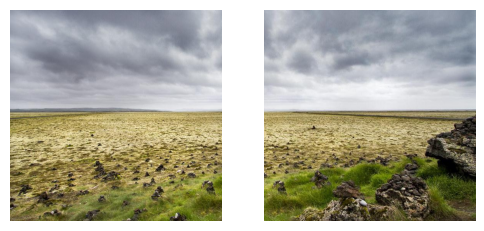

In [7]:
img1 = plt.imread(os.path.join(train_folder, '3_1.jpg'))
img2 = plt.imread(os.path.join(train_folder, '3_2.jpg'))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

And this is an example of a vertical image that got split:

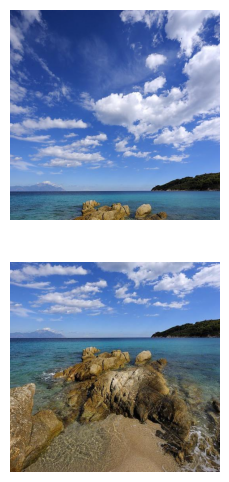

In [8]:
img1 = plt.imread(os.path.join(val_folder, '62_1.jpg'))
img2 = plt.imread(os.path.join(val_folder, '62_2.jpg'))

fig, axes = plt.subplots(2, 1, figsize=(3, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [9]:
print(f"Number of images in train folder: {len(os.listdir(train_folder))}")
print(f"Number of images in validation folder: {len(os.listdir(val_folder))}")
print(f"Number of images in test folder: {len(os.listdir(test_folder))}")

Number of images in train folder: 66
Number of images in validation folder: 21
Number of images in test folder: 22


# Images preparation and augmentation (normalization, rotations, labels)

The image loaders are created so that images can be imported while training, one batch at the time, while applying normalization, augmenting the images by rotating them 0°, 90°, 180° or 170°, and generating the one-hot encoded labels accordingly.

This code loads the train and val images from their respective directory, so that the images can be read at runtime while the model is training, avoiding filling up the RAM. The labels will be handled manually during the data augmentation process.

In [10]:
# Load the original datasets
train_dataset = image_dataset_from_directory(
    train_folder,
    image_size=(300, 300),
    batch_size=32,
    label_mode=None  # Labels will be handled manually
)

val_dataset = image_dataset_from_directory(
    val_folder,
    image_size=(300, 300),
    batch_size=32,
    label_mode=None  # Labels will be handled manually
)

Found 66 files.
Found 21 files.


The next section defines the functions to apply the data augmentation that rotates each image in each batch either 0°, 90°, 180° or 270°, normalizes the image and sets the one-hot encoded labels.

In [11]:
# Number of rotation classes (0°, 90°, 180°, 270°)
num_rotation_classes = 4

# Apply normalization and random rotations to an image and generate the one-hot encoded label
def augment_with_rotation(image):
    image = image / 255.0 # Normalize the image to the [0, 1] range
    rotation = tf.random.uniform([], minval=0, maxval=num_rotation_classes, dtype=tf.int32) # Generate a random rotation index from 0 to num_rotation_classes
    clockwise_rotation = num_rotation_classes - rotation # Reverses the rotation index, since tf.image.rot90 does counterclockwise rotations
    rotated_image = tf.image.rot90(image, k=clockwise_rotation) # Rotate the image clockwise. The 'k' argument determines how many 90° counterclockwise rotations to apply.
    label = tf.one_hot(rotation, depth=num_rotation_classes) # One-hot encode the rotation index (0, 1, 2, or 3 corresponding to 0°, 90°, 180°, 270° rotations)
    return rotated_image, label

# Apply data augmentation to the training dataset
def augment_dataset(dataset):
    return dataset.map( # For each batch of images (x), apply 'tf.map_fn' to process each image
        lambda x: tf.map_fn( # For each image in the batch, apply the 'augment_with_rotation' function
            lambda img: augment_with_rotation(img), # Apply normalization, rotation augmentation and get the one hot encoded label from each image
            x,
            fn_output_signature=(tf.float32, tf.float32) # This specifies the output types of the tf.map_fn operation
        ),
        # Automatically determine the optimal number of parallel calls to process batches more efficiently
        num_parallel_calls=tf.data.AUTOTUNE
    )

# Augment training and validation datasets by applying the rotation-based augmentation
train_augmented = augment_dataset(train_dataset)
val_augmented = augment_dataset(val_dataset)

# Optimize the data pipeline by prefetching data for improved performance during training
train_augmented = train_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)
val_augmented = val_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Test the result
for images, labels in train_augmented.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels (one-hot):\n", labels.numpy())

Images shape: (32, 300, 300, 3)
Labels shape: (32, 4)
Labels (one-hot):
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


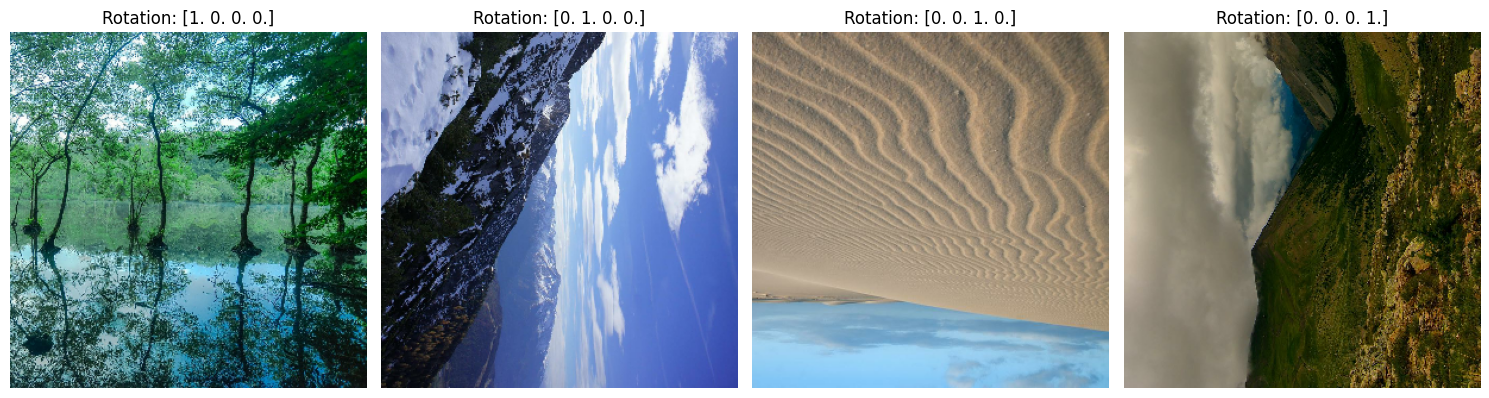

In [13]:
indexes = [2, 9, 0, 5]  # Indexes of images to display

# Set up the figure and subplots
fig, axes = plt.subplots(1, len(indexes), figsize=(15, 5))

# Plot each image with its corresponding label
for i, idx in enumerate(indexes):
    image_in_255 = (images[idx].numpy() * 255).astype("uint8") # Convert image back to 0-255 range and cast to uint8
    axes[i].imshow(image_in_255)
    axes[i].set_title(f"Rotation: {labels[idx]}")  # Display the label as the title
    axes[i].axis("off")

plt.tight_layout()
plt.show()

These outputs confirm that the functions are working as expected, rotating the images randomly and generating the labels accordingly.